In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler ,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors


In [2]:
# Read all sheets from the Excel file
sheets = ['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants']
dataframes = {sheet: pd.read_excel('/kaggle/input/e-commerce-customers/E-commerce_data.xlsx', sheet_name=sheet) for sheet in sheets}

# Merge all dataframes into one
merged_df = dataframes['customers']
for sheet in sheets[1:]:
    if sheet == 'genders':
        merged_df = pd.merge(merged_df, dataframes[sheet], on='gender_id', how='left')
    elif sheet == 'cities':
        merged_df = pd.merge(merged_df, dataframes[sheet], on='city_id', how='left')
    elif sheet == 'transactions':
        merged_df = pd.merge(merged_df, dataframes[sheet], on='customer_id', how='left')
    elif sheet == 'branches':
        merged_df = pd.merge(merged_df, dataframes[sheet], on='branch_id', how='left')
    elif sheet == 'merchants':
        merged_df = pd.merge(merged_df, dataframes[sheet], on='merchant_id', how='left')

df = merged_df.copy()
df.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,transaction_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name
0,1,2022-01-08,7,1,Male,Mansoura,178.0,2022-07-30,subscribed,SrP-866,NaT,8.0,20.0,Griffin-Leblanc
1,1,2022-01-08,7,1,Male,Mansoura,257.0,2022-09-19,burned,krI-075,2022-11-05,1.0,11.0,"Smith, Lawson and Hernandez"
2,1,2022-01-08,7,1,Male,Mansoura,1652.0,2022-06-09,burned,quk-137,2022-07-19,6.0,15.0,Butler-Gomez
3,1,2022-01-08,7,1,Male,Mansoura,1929.0,2022-07-30,burned,QiG-754,2022-10-18,8.0,20.0,Griffin-Leblanc
4,1,2022-01-08,7,1,Male,Mansoura,2352.0,2023-03-24,subscribed,OtC-985,NaT,4.0,15.0,Butler-Gomez


In [3]:
df.columns

Index(['customer_id', 'join_date', 'city_id', 'gender_id', 'gender_name',
       'city_name', 'transaction_id', 'transaction_date', 'transaction_status',
       'coupon_name', 'burn_date', 'branch_id', 'merchant_id',
       'merchant_name'],
      dtype='object')

In [4]:
df.shape

(5011, 14)

In [5]:
exclude_columns = ['customer_id', 'gender_name', 'city_name', 'coupon_name']
for col in exclude_columns :
    print(f"{col} : {df[col].nunique()}")
    print(df[col].value_counts().nlargest(5).to_string(header=False))
    print('\n', '----' * 10, '\n')


customer_id : 1000
822    14
726    13
73     12
471    12
776    12

 ---------------------------------------- 

gender_name : 2
Male      2572
Female    2439

 ---------------------------------------- 

city_name : 20
Cairo        338
Port Said    321
Aswan        298
Giza         291
Fayyum       273

 ---------------------------------------- 

coupon_name : 5000
SrP-866    1
YJw-177    1
bNI-266    1
XlP-042    1
ofR-396    1

 ---------------------------------------- 



In [6]:
# summary statistics
print(df.describe())

       customer_id                      join_date      city_id    gender_id  \
count  5011.000000                           5011  5011.000000  5011.000000   
mean    509.497705  2023-01-18 20:31:39.501097728    10.093195     1.486729   
min       1.000000            2021-07-18 00:00:00     1.000000     1.000000   
25%     262.000000            2022-04-10 00:00:00     5.000000     1.000000   
50%     514.000000            2023-01-11 00:00:00    10.000000     1.000000   
75%     758.000000            2023-10-25 00:00:00    15.000000     2.000000   
max    1000.000000            2024-07-13 00:00:00    20.000000     2.000000   
std     287.165668                            NaN     5.862692     0.499874   

       transaction_id            transaction_date  \
count     5000.000000                        5000   
mean      2500.500000  2023-10-22 04:38:47.040000   
min          1.000000         2021-08-05 00:00:00   
25%       1250.750000         2023-05-31 18:00:00   
50%       2500.500000  

# EDA 📊

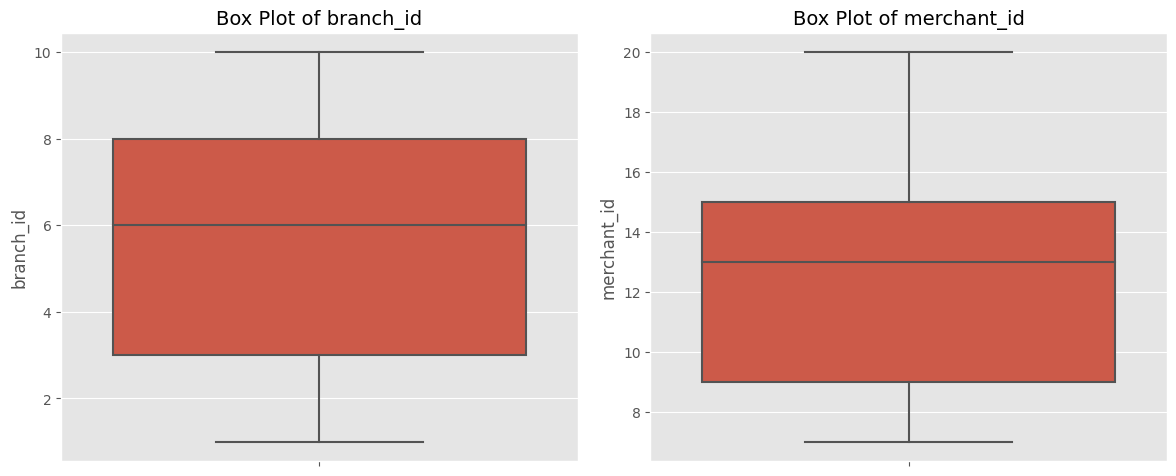

In [7]:
# Detecting outliers in our data
columns_to_plot = ['branch_id', 'merchant_id']

# Create a list of numeric columns
numeric_columns = [col for col in columns_to_plot if df[col].dtype in ['int64', 'float64']]

# Calculate the number of rows and columns for the subplot grid
n_plots = len(numeric_columns)
n_rows = (n_plots - 1) // 3 + 1
n_cols = min(3, n_plots)

# Create the subplot grid
fig = plt.figure(figsize=(6 * n_cols, 5 * n_rows))

# Create box plots for each numeric column
for i, col in enumerate(numeric_columns):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(f'Box Plot of {col}', fontsize=14)

# Adjust the layout and style
plt.tight_layout()
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

plt.tight_layout()
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
plt.show()



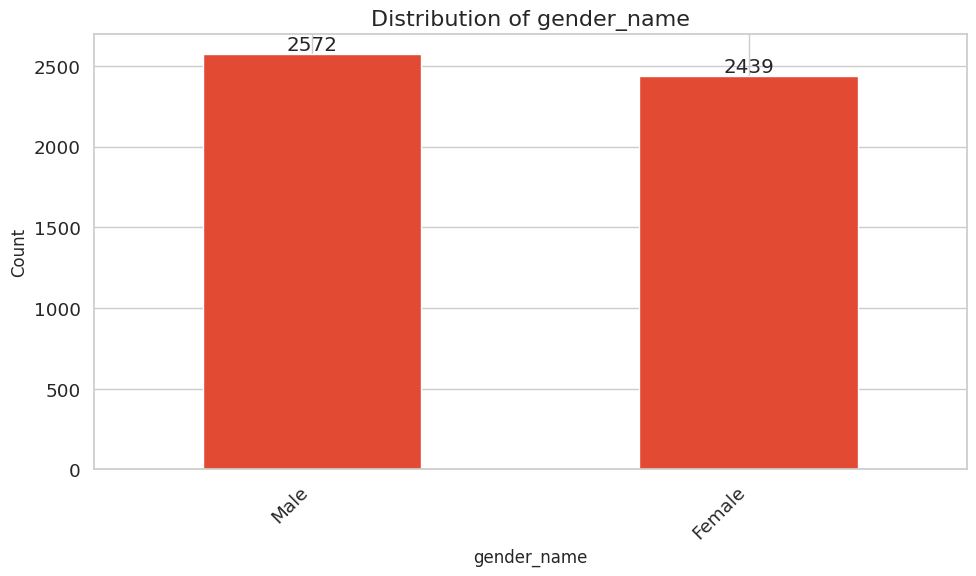

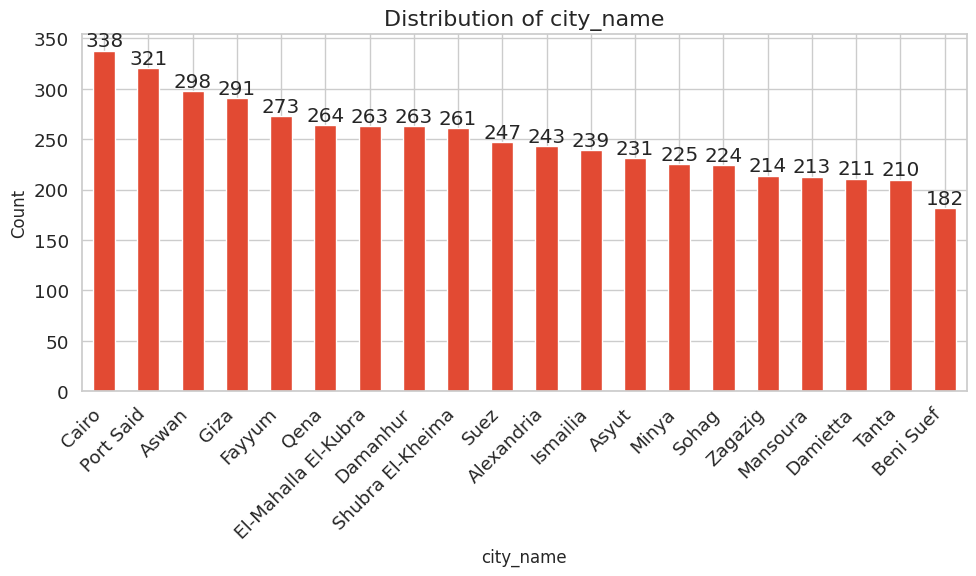

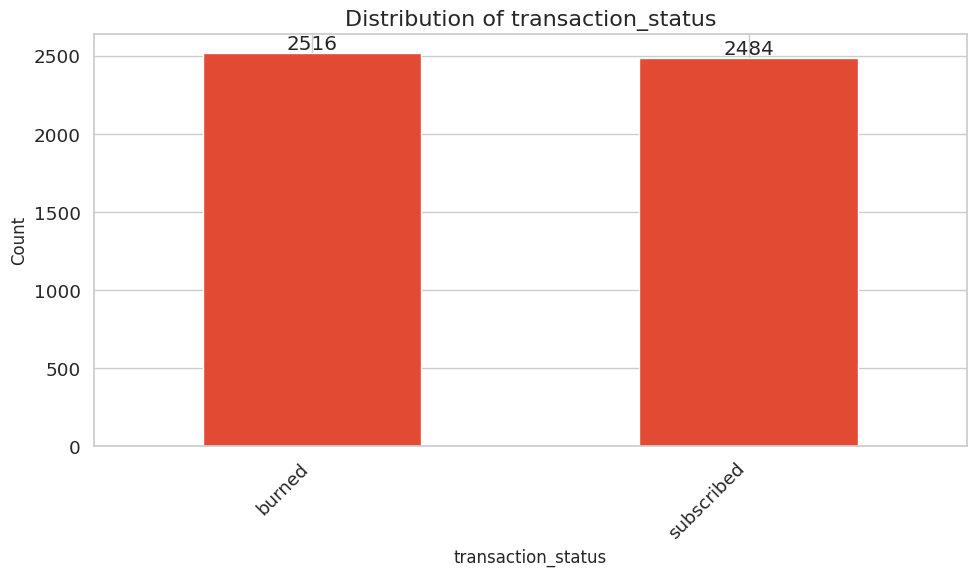

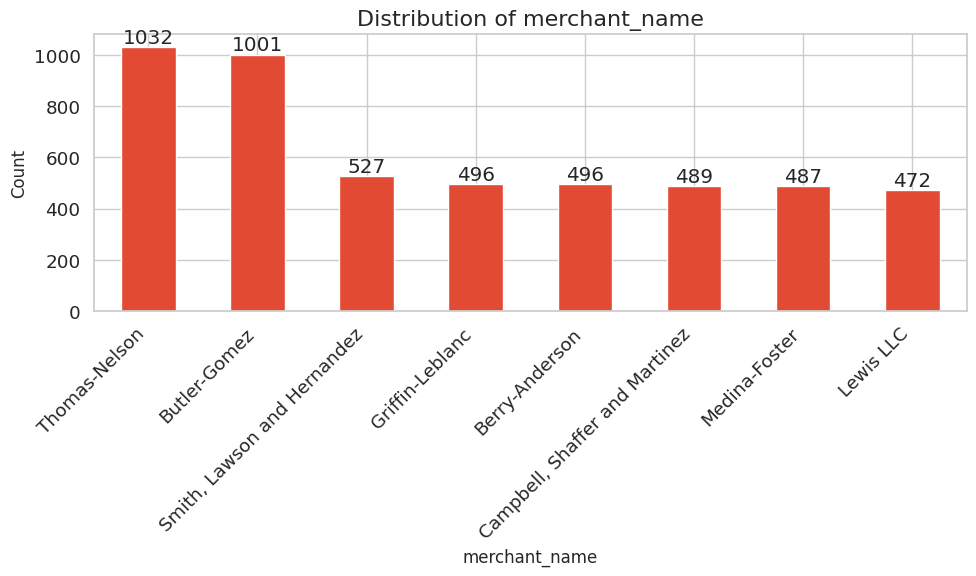

In [8]:
# Create bar plots for each objects columns to see distributions

# Get object columns, excluding 'coupon_name' and 'burn_date'
object_columns = [col for col in df.select_dtypes(include=['object']).columns if col not in ['coupon_name', 'burn_date']]

# Create a separate figure for each object column
for col in object_columns:
    plt.figure(figsize=(10, 6))
    value_counts = df[col].value_counts()
    ax = value_counts.plot(kind='bar')
    plt.title(f'Distribution of {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for i, v in enumerate(value_counts):
        ax.text(i, v, str(v), ha='center', va='bottom')
    
    # Adjust the layout and style
    plt.tight_layout()
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)
    plt.show()


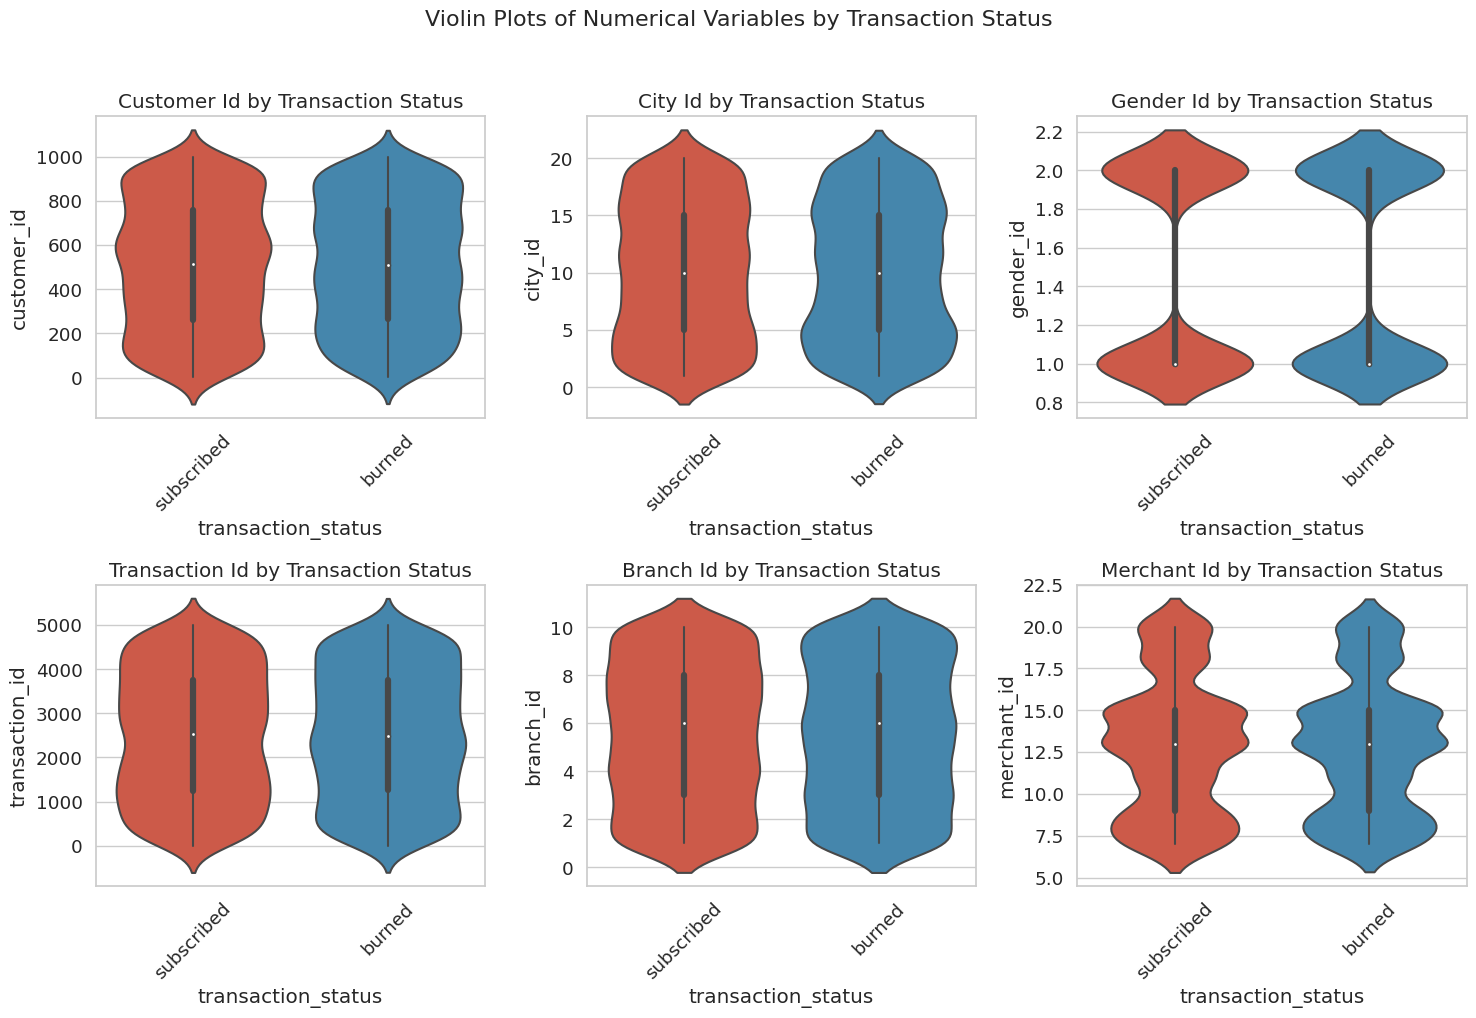

In [9]:
# Create a parallel coordinates plot for numerical columns

# Select numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()


# Create a violin plot for numerical columns grouped by transaction status
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.violinplot(x='transaction_status', y=col, data=df)
    plt.title(f'{col.replace("_", " ").title()} by Transaction Status')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle('Violin Plots of Numerical Variables by Transaction Status', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


<Figure size 1500x800 with 0 Axes>

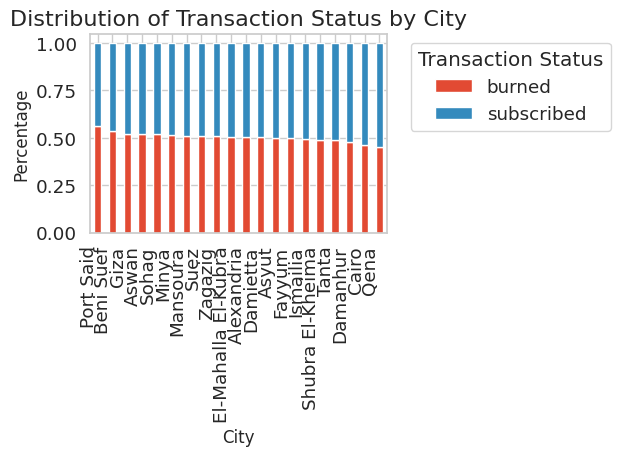

In [10]:
# Calculate the percentage of each transaction status for each city
status_by_city = df.groupby(['city_name', 'transaction_status']).size().unstack(fill_value=0)
status_by_city_pct = status_by_city.div(status_by_city.sum(axis=1), axis=0)

# Sort cities by the percentage of 'burned' transactions
sorted_cities = status_by_city_pct.sort_values('burned', ascending=False).index

# stacked bar plot
plt.figure(figsize=(15, 8))
status_by_city_pct.loc[sorted_cities].plot(kind='bar', stacked=True)
plt.title('Distribution of Transaction Status by City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Transaction Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()



In [11]:
# Group data by merchant and transaction status
grouped_data = df.groupby(['merchant_name', 'transaction_status']).size().reset_index(name='count')

# Create the treemap
fig = px.treemap(grouped_data, 
                 path=['merchant_name', 'transaction_status'], 
                 values='count',
                 color='transaction_status',
                 color_discrete_map={'burned': 'red', 'subscribed': 'green'},
                 title='Hierarchy of Transactions by Merchant and Status')
fig.update_layout(width=1000, height=600)
fig.show()


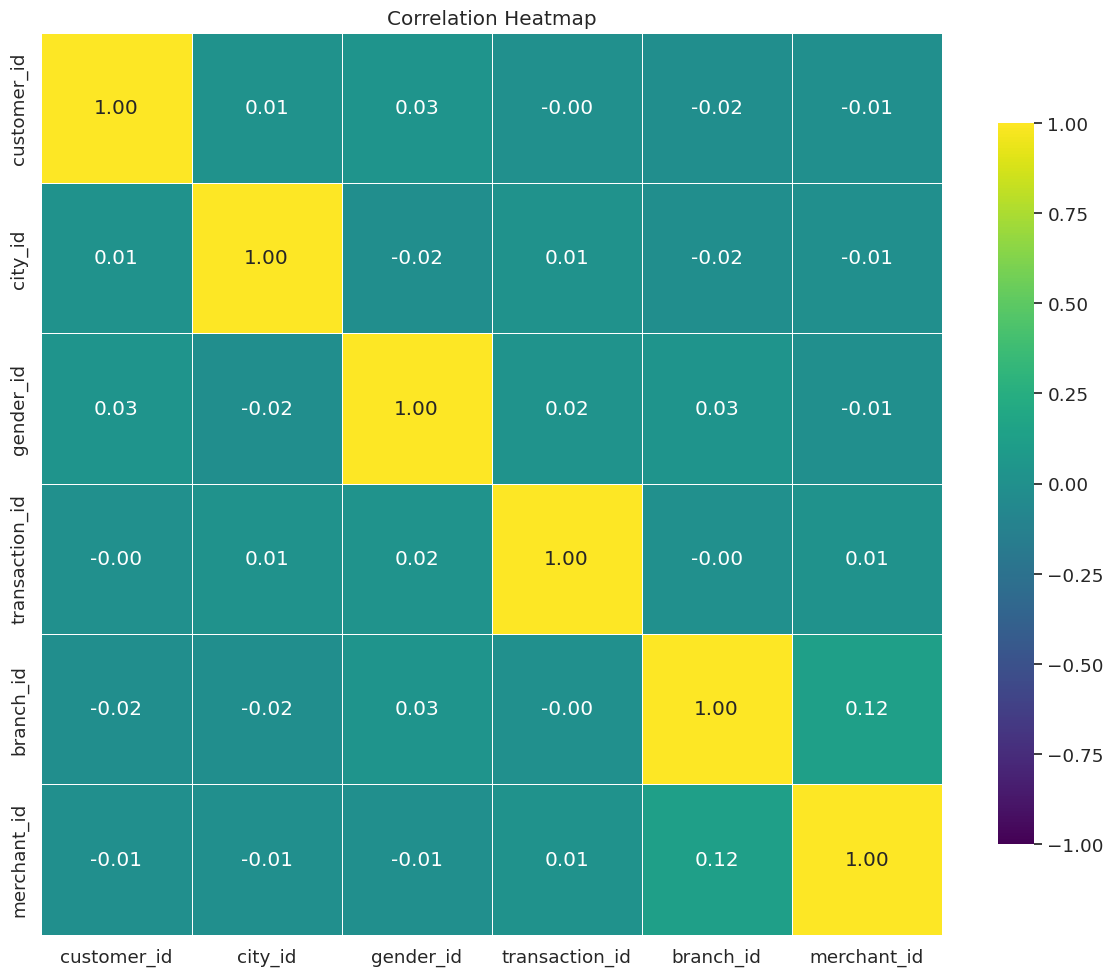

In [12]:
# Correlation heatmap
df_numeric = df.select_dtypes(include=['int64','float'])  # Filter Numeric Columns
plt.figure(figsize=(12,10))
corr = df_numeric.corr()
sns.heatmap(data=corr, annot=True, cmap='viridis', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()



# Insights from the Visualizations

These plots provide valuable insights for stakeholders:

1. The stacked bar plot shows the distribution of transaction statuses across different cities,
   helping identify which cities have higher rates of burned or subscribed transactions.

2. The treemap visualizes the hierarchy of transactions by merchant and status,
   allowing stakeholders to quickly identify which merchants have the most transactions
   and how they are distributed between burned and subscribed statuses.


# Data Cleaning
1. Handle missing values
2. Duplicated values
3. Datatype of Each columns are correct or not
4. Find Outliers if Any
5. Remove unnecessary columns

In [13]:
# check for missing values in each columns
null_columns = df.columns[df.isnull().any()].tolist()
null_indices = {col: df.index[df[col].isnull()].tolist() for col in null_columns}
print(df.isnull().sum())
    


customer_id              0
join_date                0
city_id                  0
gender_id                0
gender_name              0
city_name                0
transaction_id          11
transaction_date        11
transaction_status      11
coupon_name             11
burn_date             2495
branch_id               11
merchant_id             11
merchant_name           11
dtype: int64


In [14]:
df['burn_date'] = df['burn_date'].fillna('no burn data')

In [15]:
# check if there is any duplicated values
df.duplicated().sum()

0

In [16]:
# Check if the dtypes of columns are correct
print("Current data types:")
print(df.dtypes)

Current data types:
customer_id                    int64
join_date             datetime64[ns]
city_id                        int64
gender_id                      int64
gender_name                   object
city_name                     object
transaction_id               float64
transaction_date      datetime64[ns]
transaction_status            object
coupon_name                   object
burn_date                     object
branch_id                    float64
merchant_id                  float64
merchant_name                 object
dtype: object


In [17]:
# Create a new feature: days since the customer joined
df['days_since_join'] = (df['transaction_date'] - df['join_date']).dt.days


## `Note` Null value in transactions department so will keep it for now until feature  selection process  

In [18]:
# Remove unnecessary columns
columns_to_drop = ['gender_id', 'city_id','transaction_id', 'coupon_name', 'merchant_name']
df = df.drop(columns=columns_to_drop)


# Data Preprocessing

## Encode categorical variables (Gender, City)

In [19]:
le = LabelEncoder()

# Apply label encoding to 'gender_name' and 'city_name' columns
df['gender_name'] = le.fit_transform(df['gender_name'])
df['city_name'] = le.fit_transform(df['city_name'])


## Data Aggregation

In [20]:
df['days_since_first_transaction'] = (df['transaction_date'] - df['join_date']).dt.days
# Aggregation by customer
customer_agg = df.groupby('customer_id').agg(
    total_transactions=('transaction_status', 'count'),
    subscribed_transactions=('transaction_status', lambda x: (x == 'subscribed').sum()),
    burned_transactions=('transaction_status', lambda x: (x == 'burned').sum()),
    days_since_first_transaction=('days_since_first_transaction', 'max')
)

In [21]:
# Concatenate the encoded features and customer aggregation
final_df = pd.concat([
    df[['customer_id', 'gender_name', 'city_name']],
    customer_agg.reset_index()
], axis=1)

# Drop any duplicate columns that might have been created during concatenation
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# Reset the index to ensure proper alignment
final_df.reset_index(drop=True, inplace=True)

print("Shape of final dataset:", final_df.shape)

final_df.head(5)

Shape of final dataset: (5011, 7)


,customer_id,gender_name,city_name,total_transactions,subscribed_transactions,burned_transactions,days_since_first_transaction
0,1,1,11,7.0,4.0,3.0,869.0
1,1,1,11,3.0,2.0,1.0,172.0
2,1,1,11,5.0,4.0,1.0,418.0
3,1,1,11,1.0,1.0,0.0,51.0
4,1,1,11,4.0,1.0,3.0,433.0


# Explanation of columns:
1. Original customer_id, gender_name, and city_name columns
2. Aggregated features (4 columns: total_transactions, subscribed_transactions, burned_transactions, days_since_first_transaction)
3. The number of columns is relatively small as we're using the encoded categorical variables directly.

In [22]:
# Data Preparation
features = ['total_transactions', 'subscribed_transactions', 'burned_transactions', 'days_since_first_transaction']
final_df_clean = final_df.dropna(subset=features)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(final_df_clean[features])

In [23]:
# Split Our Dataset
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

# K-Means Clustering
def perform_kmeans(X, k_range):
    results = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        results.append({
            'k': k,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette_score(X, labels)
        })
    return results

k_range = range(2, 11)
kmeans_results = perform_kmeans(X_train, k_range)

# Find optimal k based on Silhouette Score
optimal_k = max(kmeans_results, key=lambda x: x['silhouette'])['k']

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
train_clusters = kmeans_final.fit_predict(X_train)


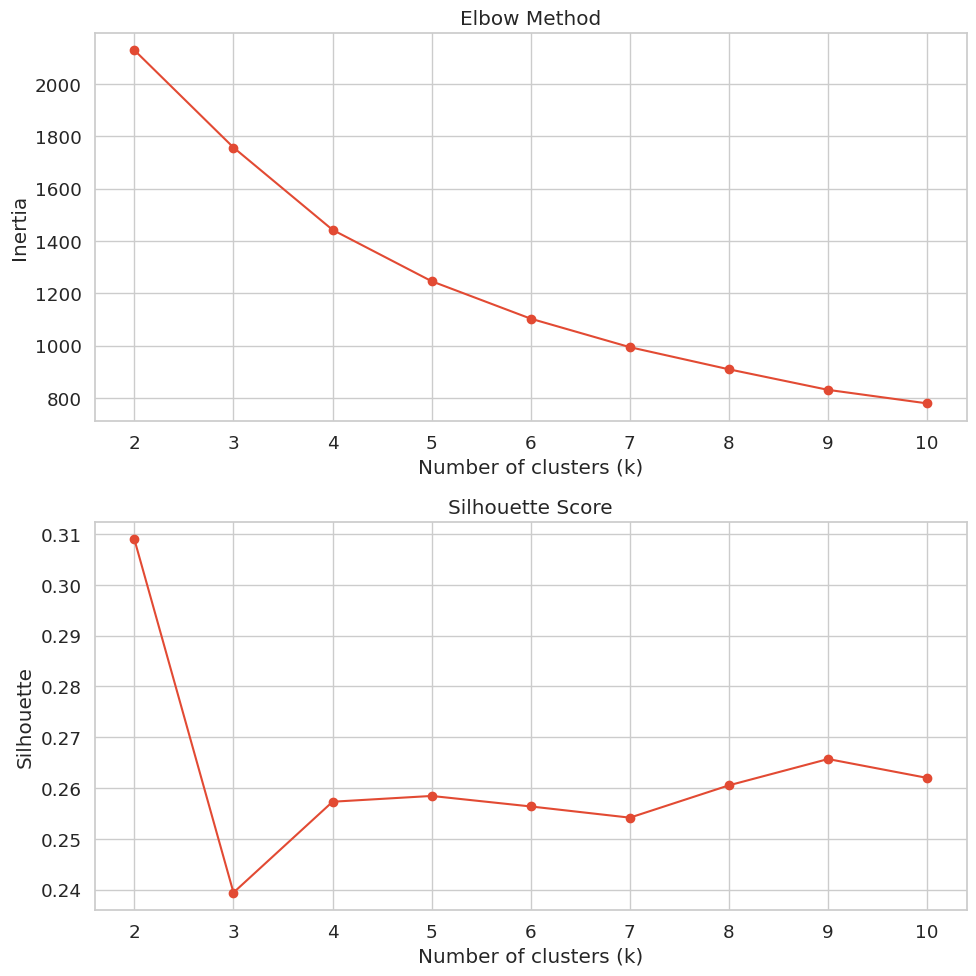

Optimal number of clusters based on Silhouette Score: 2


In [24]:
# Visualize K-Means results
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
metrics = ['inertia', 'silhouette']
titles = ['Elbow Method', 'Silhouette Score']
for i, (metric, title) in enumerate(zip(metrics, titles)):
    axs[i].plot(k_range, [r[metric] for r in kmeans_results], marker='o')
    axs[i].set_title(title)
    axs[i].set_xlabel('Number of clusters (k)')
    axs[i].set_ylabel(metric.capitalize())
plt.tight_layout()
plt.show()

# Choose optimal k based on Silhouette Score
optimal_k = max(kmeans_results, key=lambda x: x['silhouette'])['k']
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

In [25]:
# DBSCAN Clustering
def perform_dbscan(X, eps_range, min_samples_range):
    results = []
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            if len(set(labels)) > 1:  # Ensure more than one cluster
                results.append({
                    'eps': eps,
                    'min_samples': min_samples,
                    'silhouette': silhouette_score(X, labels),
                    'n_clusters': len(set(labels)) - (1 if -1 in labels else 0),
                    'n_noise': list(labels).count(-1)
                })
    return results

eps_range = np.arange(0.1, 1.1, 0.1)
min_samples_range = range(3, 11)
dbscan_results = perform_dbscan(X_train, eps_range, min_samples_range)

# Choose optimal DBSCAN parameters
optimal_dbscan = max(dbscan_results, key=lambda x: x['silhouette'])
print(f"Optimal DBSCAN parameters: eps={optimal_dbscan['eps']}, min_samples={optimal_dbscan['min_samples']}")

# Fit final DBSCAN model
dbscan_final = DBSCAN(eps=optimal_dbscan['eps'], min_samples=optimal_dbscan['min_samples'])
dbscan_clusters = dbscan_final.fit_predict(X_train)


Optimal DBSCAN parameters: eps=1.0, min_samples=3


In [26]:
# Compare K-Means and DBSCAN results
print("\nComparison of K-Means and DBSCAN clustering:")
print(f"K-Means Silhouette Score: {silhouette_score(X_train, train_clusters):.4f}")
print(f"DBSCAN Silhouette Score: {optimal_dbscan['silhouette']:.4f}")

# Choose the best model based on Silhouette Score
if silhouette_score(X_train, train_clusters) > optimal_dbscan['silhouette']:
    print("\nK-Means is the better model for this dataset.")
    best_model = kmeans_final
    best_clusters = train_clusters
else:
    print("\nDBSCAN is the better model for this dataset.")
    best_model = dbscan_final
    best_clusters = dbscan_clusters


Comparison of K-Means and DBSCAN clustering:
K-Means Silhouette Score: 0.3090
DBSCAN Silhouette Score: 0.4671

DBSCAN is the better model for this dataset.


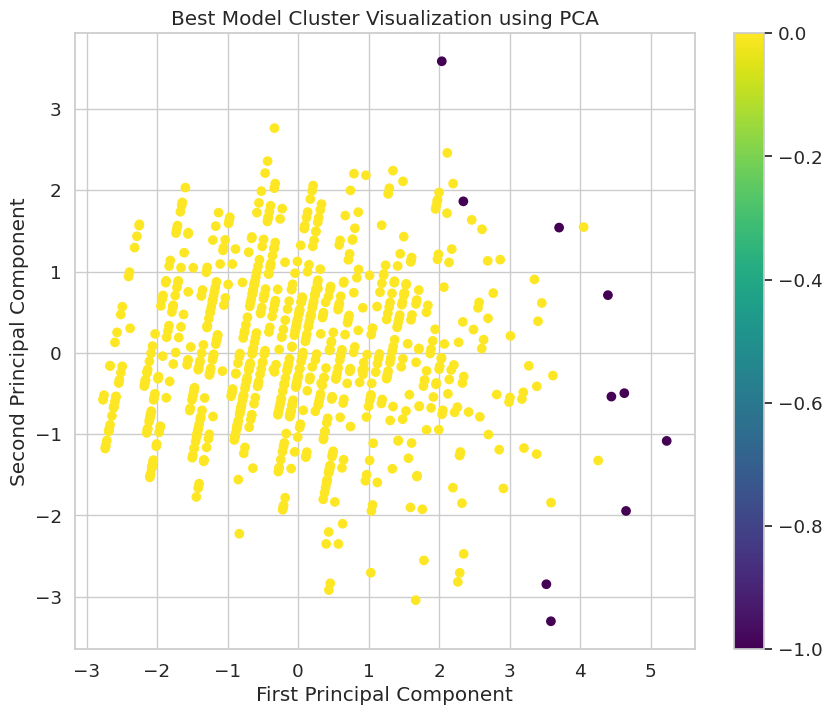

In [27]:
# Visualize best model clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_clusters, cmap='viridis')
plt.title('Best Model Cluster Visualization using PCA')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter)
plt.show()

# Clustering Analysis Summary:
1. K-Means and DBSCAN clustering methods were applied and compared using Silhouette Score.
2. The best model was chosen based on the higher Silhouette Score.
3. The next step is to analyze the characteristics of each cluster to create customer segments.
4. These segments can be used to tailor marketing strategies and improve customer experience.
5. Further analysis may include feature importance and segment profiling.